# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - пошаговый шаблон для выполнения проекта по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

Внимание: вам нужно реализовать весь рабочий код - в ноутбуке предустановлены только парсеры строкового формата. Все остальные ячейки служат как инструкции / места для вашего кода.


#### Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



##### Подготовка окружения (пути, seed, imports)

In [6]:
import os
import random
import re
from collections import Counter
from typing import List, Tuple, cast

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from datasets import Dataset, DatasetDict
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score as f1_score_ner
from sklearn.metrics import f1_score as f1_score_cls
from sklearn.metrics import precision_score, recall_score
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from transformers import (
    AutoModel,
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    get_linear_schedule_with_warmup,
)
from tqdm import tqdm

In [7]:
nltk.download("punkt_tab")
nltk.download("punkt")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Салтанат\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Салтанат\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
def fix_all_seeds(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f"Все сиды зафиксированы: {seed}")


RANDOM_SEED = 42
fix_all_seeds(RANDOM_SEED)

DATA_DIR = "data/"
# MODEL_SAVE_PATH = './models/'

data_train_path = os.path.join(DATA_DIR, "train.jsonl")
data_val_path = os.path.join(DATA_DIR, "val.jsonl")
data_test_path = os.path.join(DATA_DIR, "test.jsonl")

data_entities_path = os.path.join(DATA_DIR, "ent_types.jsonl")
data_relations_path = os.path.join(DATA_DIR, "rel_types.jsonl")

Все сиды зафиксированы: 42


In [9]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

sns.set_style("white")
sns.set_theme(style="whitegrid")

##### 1. EDA

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).




In [20]:
# Читаем и отображаем первые 200 строк тренировочного датасета
data_train = pd.read_json(
    data_train_path,
    lines=True,
).head(
    200
)  # nrows=200)
display(data_train)
# Проверяем типы данных в столбцах 'entities' и 'relations'
first_item = data_train["entities"].iloc[0]
display(f"Тип в первой строке признака entities {type(first_item)}")
first_item = data_train["relations"].iloc[0]
display(f"Тип в первой строке признака relations {type(first_item)}")

,id,text,entities,relations,links
0,0,"Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке\n\n05/08/2008 10:35\n\nБИШ...","[T1\tNATIONALITY 62 74\tамериканцами, T2\tCITY 82 89\tБишкеке, T3\tDATE 117 126\t5 августа, T4\tCOUNTRY 136 142\tГру...","[R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE_IS Arg1:T101 Arg2:T13, R3\tHEADQUARTERED_IN Arg1:T72 Arg2:T4, R4\tHEA...","[N1\tReference T5 Wikidata:Q813\tКиргизия, N2\tReference T10 Wikidata:Q6589202\tминистерство внутренних дел, N3\tRef..."
1,1,Муртаза Рахимов чистит кадры\n\t\nПрезидент Башкирии Муртаза Рахимов в очередной раз решил поменять главу своей адми...,"[T1\tPERSON 0 15\tМуртаза Рахимов, T2\tPROFESSION 31 40\tПрезидент, T3\tPERSON 50 65\tМуртаза Рахимов, T4\tPROFESSIO...","[R1\tWORKS_AS Arg1:T3 Arg2:T76, R2\tWORKS_AS Arg1:T8 Arg2:T9, R3\tWORKPLACE Arg1:T78 Arg2:T80, R4\tAGE_IS Arg1:T18 A...","[N1\tReference T9 Wikidata:NULL\t, N2\tReference T10 Wikidata:NULL\t, N3\tReference T13 Wikidata:NULL\t, N4\tReferen..."
2,2,"Россия задерживает поставку генсека\n\t\nСегодня в Дохе открывается заседание Форума стран-экспортеров газа (ФСЭГ), ...","[T1\tCOUNTRY 0 6\tРоссия, T2\tCITY 48 52\tДохе, T3\tDATE 38 45\tСегодня, T4\tORGANIZATION 75 104\tФорума стран-экспо...","[R1\tALTERNATIVE_NAME Arg1:T4 Arg2:T5, R2\tORGANIZES Arg1:T4 Arg2:T124, R3\tTAKES_PLACE_IN Arg1:T124 Arg2:T2, R4\tPO...","[N1\tReference T5 Wikidata:Q1031255\tФорум стран-экспортёров газа, N2\tReference T18 Wikidata:Q656\tСанкт-Петербург,..."
3,3,"Российские менеджеры отказались возглавлять ""газовую ОПЕК""\nПравительство России не смогло найти кандидатуру генерал...","[T1\tCOUNTRY 0 10\tРоссийские, T2\tORGANIZATION 59 72\tПравительство, T3\tPROFESSION 108 130\tгенерального секретаря...","[R1\tALTERNATIVE_NAME Arg1:T80 Arg2:T4, R2\tALTERNATIVE_NAME Arg1:T80 Arg2:T97, R3\tTAKES_PLACE_IN Arg1:T8 Arg2:T9, ...","[N1\tReference T3 Wikidata:Q6501749\tгенеральный секретарь, N2\tReference T5 Wikidata:Q1780189\tКоммерсантъ, N3\tRef..."
4,4,Facebook нашел нового финансового директора\nФинансовым директором социальной сети Facebook назначен 39-летний Дэвид...,"[T1\tORGANIZATION 0 8\tFacebook, T2\tPROFESSION 22 43\tфинансового директора, T3\tPROFESSION 44 65\tФинансовым дирек...","[R1\tAGE_IS Arg1:T6 Arg2:T5, R2\tALTERNATIVE_NAME Arg1:T6 Arg2:T7, R3\tWORKPLACE Arg1:T6 Arg2:T4, R4\tWORKS_AS Arg1:...","[N1\tReference T13 Wikidata:Q899140\tGenentech, N2\tReference T26 Wikidata:Q5233251\tДэвид Эберсман, N3\tReference T..."
...,...,...,...,...,...
195,195,Состоялось открытие выставки «„Песочные часы“: Рисунки Иосифа Бродского»\nНакануне в зале Корфа в Главном здании Рос...,"[T1\tEVENT 30 71\t„Песочные часы“: Рисунки Иосифа Бродского, T2\tPERSON 161 177\tИосифа Бродского, T3\tPERSON 55 71\...","[R1\tHEADQUARTERED_IN Arg1:T23 Arg2:T22, R2\tOWNER_OF Arg1:T23 Arg2:T4, R3\tPART_OF Arg1:T20 Arg2:T4, R4\tWORKS_AS A...","[N1\tReference T3 Wikidata:Q862\tИосиф Александрович Бродский, N2\tReference T4 Wikidata:NULL\t, N3\tReference T10 W..."
196,196,"Теракт в Иерусалиме: убиты двое полицейских\nПогибшие в результате теракта полицейские\nВ пятницу, 14 июля 2017 года...","[T1\tEVENT 0 6\tТеракт, T2\tCITY 9 19\tИерусалиме, T3\tNUMBER 27 31\tдвое, T4\tDATE 86 114\tВ пятницу, 14 июля 2017 ...","[R1\tLOCATED_IN Arg1:T6 Arg2:T5, R2\tLOCATED_IN Arg1:T5 Arg2:T61, R3\tLOCATED_IN Arg1:T9 Arg2:T10, R4\tLOCATED_IN Ar...","[N1\tReference T5 Wikidata:Q212938\tВосточный Иерусалим, N2\tReference T9 Wikidata:Q1450403\tЛьвиные ворота, N3\tRef..."
197,197,Многодетный хакер из Тюмени осуждён за взлом восьми сайтов\nНоутбук Asus\nТюменский районный суд вынес приговор в от...,"[T1\tCITY 21 27\tТюмени, T2\tNUMBER 45 51\tвосьми, T3\tPRODUCT 67 71\tAsus, T4\tAGE 122 132\t36-летнего, T5\tPERSON ...","[R1\tHEADQUARTERED_IN Arg1:T23 Arg2:T24, R2\tAGE_IS Arg1:T5 Arg2:T4, R3\tALTERNATIVE_NAME Arg1:T5 Arg2:T10, R4\tHEAD...","[N1\tReference T5 Wikidata:Q4212355\tКандыба, Андрей Фёдорович, N2\tReference T6 Wikidata:NULL\t, N3\tReference T12 ..."


"Тип в первой строке признака entities <class 'list'>"

"Тип в первой строке признака relations <class 'list'>"

In [21]:
# Читаем и отображаем типы сущностей из файла ent_types.jsonl
data_ent_types = pd.read_json(data_entities_path, lines=True)
display(data_ent_types.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
type,AGE,AWARD,CITY,COUNTRY,CRIME,DATE,DISEASE,DISTRICT,EVENT,FACILITY,FAMILY,IDEOLOGY,LANGUAGE,LAW,LOCATION,MONEY,NATIONALITY,NUMBER,ORDINAL,ORGANIZATION,PENALTY,PERCENT,PERSON,PRODUCT,PROFESSION,RELIGION,STATE_OR_PROVINCE,TIME,WORK_OF_ART
link,,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,,,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,,<NORM>:Wikidata,,,<NORM>:Wikidata,,,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,<NORM>:Wikidata,,<NORM>:Wikidata


In [22]:
# Читаем и отображаем типы отношений из файла rel_types.jsonl
data_rel_types = pd.read_json(data_relations_path, lines=True)
display(data_rel_types)

,type,arg1,arg2
0,ABBREVIATION,[<ENTITY>],[<ENTITY>]
1,KNOWS,"[PERSON, PROFESSION]",[<ENTITY>]
2,AGE_IS,[<ENTITY>],[AGE]
3,AGE_DIED_AT,"[PERSON, PROFESSION]",[AGE]
4,ALTERNATIVE_NAME,[<ENTITY>],[<ENTITY>]
5,AWARDED_WITH,"[PERSON, PROFESSION, ORGANIZATION, WORK_OF_ART, NATIONALITY]",[AWARD]
6,PLACE_OF_BIRTH,"[PERSON, PROFESSION]","[CITY, COUNTRY, DISTRICT, FACILITY, LOCATION, STATE_OR_PROVINCE]"
7,CAUSE_OF_DEATH,"[PERSON, PROFESSION, NATIONALITY]","[DISEASE, EVENT]"
8,DATE_DEFUNCT_IN,"[CITY, COUNTRY, DISTRICT, FACILITY, EVENT, ORGANIZATION, STATE_OR_PROVINCE, WORK_OF_ART]",[DATE]
9,DATE_FOUNDED_IN,"[CITY, COUNTRY, DISTRICT, FACILITY, EVENT, LOCATION, ORGANIZATION, STATE_OR_PROVINCE, WORK_OF_ART]",[DATE]


In [23]:
# Подсчёт количества сущностей по типам в тренировочном датасете
entity_counts = Counter()

for entities_list in data_train["entities"]:
    for entity_string in entities_list:
        # Разрезаем по табуляции и берем вторую часть
        # "T1\tNATIONALITY 62 74\tамериканцами" -> "NATIONALITY 62 74"
        parts = entity_string.split("\t")
        if len(parts) > 1:
            # Берем первое слово из второй части: "NATIONALITY"
            ent_type = parts[1].split(" ")[0]
            entity_counts[ent_type] += 1

display(entity_counts.most_common())

[('PERSON', 2055),
 ('PROFESSION', 1893),
 ('ORGANIZATION', 1692),
 ('DATE', 1125),
 ('COUNTRY', 1024),
 ('EVENT', 986),
 ('CITY', 467),
 ('NUMBER', 399),
 ('LAW', 240),
 ('AGE', 215),
 ('NATIONALITY', 186),
 ('ORDINAL', 182),
 ('FACILITY', 159),
 ('AWARD', 156),
 ('IDEOLOGY', 149),
 ('STATE_OR_PROVINCE', 132),
 ('WORK_OF_ART', 126),
 ('DISEASE', 112),
 ('CRIME', 99),
 ('MONEY', 96),
 ('PRODUCT', 81),
 ('LOCATION', 79),
 ('PENALTY', 66),
 ('DISTRICT', 63),
 ('TIME', 57),
 ('RELIGION', 26),
 ('PERCENT', 16),
 ('FAMILY', 15),
 ('LANGUAGE', 14)]

In [24]:
# Подсчёт количества отношений по типам в тренировочном датасете
relations_counts = Counter()

for relations_list in data_train["relations"]:
    for relation_string in relations_list:
        # Разрезаем по табуляции и берем вторую часть
        parts = relation_string.split("\t")
        if len(parts) > 1:
            relation_type = parts[1].split(" ")[0]
            relations_counts[relation_type] += 1

display(relations_counts.most_common())

[('WORKPLACE', 1080),
 ('WORKS_AS', 961),
 ('ALTERNATIVE_NAME', 927),
 ('PARTICIPANT_IN', 807),
 ('ORIGINS_FROM', 452),
 ('HEADQUARTERED_IN', 424),
 ('POINT_IN_TIME', 407),
 ('TAKES_PLACE_IN', 360),
 ('LOCATED_IN', 270),
 ('AGENT', 266),
 ('AGE_IS', 182),
 ('PRODUCES', 164),
 ('AWARDED_WITH', 125),
 ('HAS_CAUSE', 121),
 ('IDEOLOGY_OF', 105),
 ('MEMBER_OF', 101),
 ('PART_OF', 99),
 ('PARENT_OF', 89),
 ('SUBORDINATE_OF', 87),
 ('PLACE_RESIDES_IN', 83),
 ('INANIMATE_INVOLVED', 68),
 ('MEDICAL_CONDITION', 68),
 ('CONVICTED_OF', 66),
 ('DATE_OF_CREATION', 66),
 ('KNOWS', 64),
 ('OWNER_OF', 63),
 ('ABBREVIATION', 57),
 ('SUBEVENT_OF', 51),
 ('SIBLING', 51),
 ('ORGANIZES', 49),
 ('FOUNDED_BY', 49),
 ('DATE_OF_BIRTH', 42),
 ('SPOUSE', 40),
 ('PLACE_OF_BIRTH', 37),
 ('DATE_OF_DEATH', 35),
 ('RELIGION_OF', 27),
 ('PENALIZED_AS', 26),
 ('PLACE_OF_DEATH', 26),
 ('AGE_DIED_AT', 24),
 ('INCOME', 23),
 ('SCHOOLS_ATTENDED', 21),
 ('PRICE_OF', 21),
 ('EXPENDITURE', 16),
 ('DATE_FOUNDED_IN', 16),
 ('STA

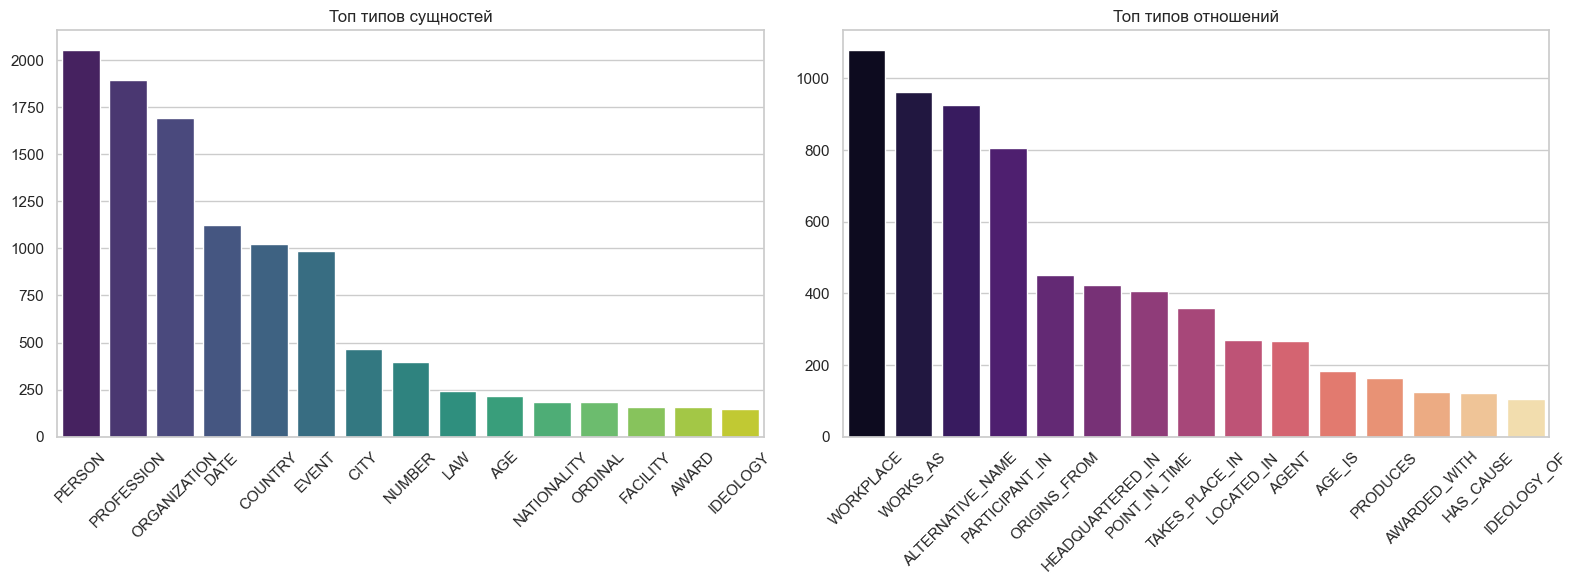

In [25]:
# Визуализация распределения типов сущностей и отношений
figure, ax = plt.subplots(1, 2, figsize=(16, 6))
entity_types, entity_values = zip(*entity_counts.most_common(15))
relation_types, relation_values = zip(*relations_counts.most_common(15))

sns.barplot(
    x=entity_types,
    y=entity_values,
    ax=ax[0],
    palette="viridis",
    hue=entity_types,
    legend=False,
)
ax[0].set_title("Топ типов сущностей")
ax[0].tick_params(axis="x", rotation=45)


sns.barplot(
    x=relation_types,
    y=relation_values,
    ax=ax[1],
    palette="magma",
    hue=relation_types,
    legend=False,
)
ax[1].set_title("Топ типов отношений")
ax[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

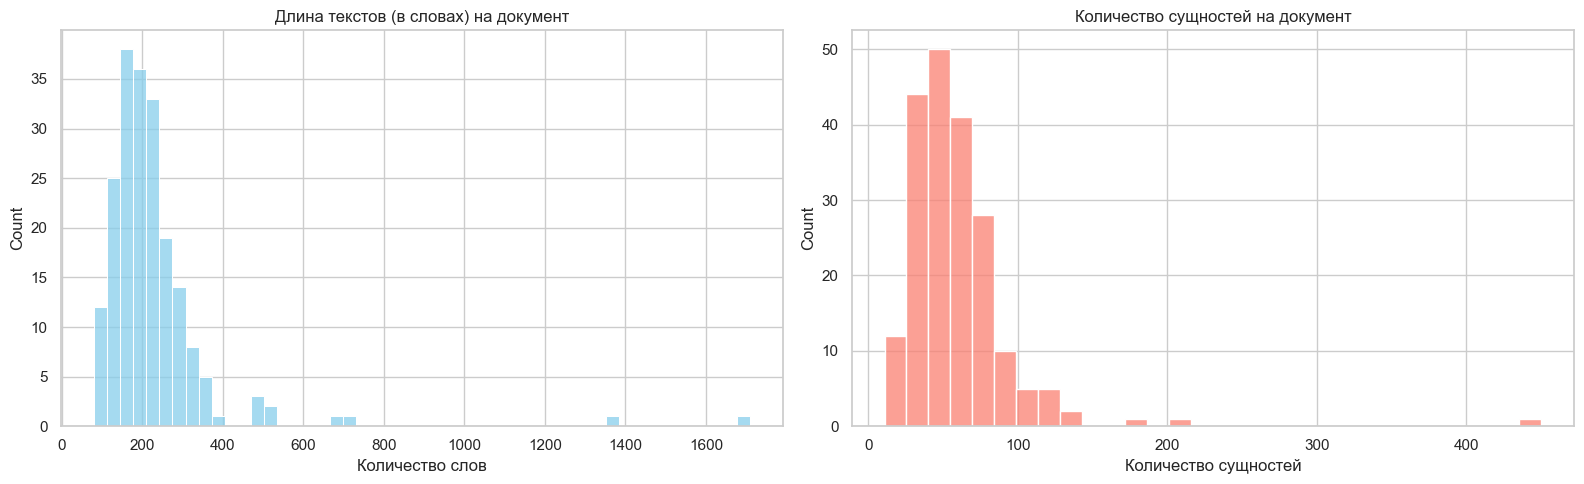

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Левый график: Длина текста
text_lens = data_train["text"].apply(lambda x: len(x.split()))
sns.histplot(x=text_lens, ax=ax[0], bins=50, color="skyblue")
ax[0].set_title("Длина текстов (в словах) на документ")
ax[0].set_xlabel("Количество слов")

# Правый график: Кол-во сущностей
ent_counts = data_train["entities"].apply(len)
sns.histplot(x=ent_counts, ax=ax[1], bins=30, color="salmon")
ax[1].set_title("Количество сущностей на документ")
ax[1].set_xlabel("Количество сущностей")

plt.tight_layout()
plt.show()

In [27]:
text_lens.describe()

count     200.0000
mean      227.6600
std       163.2002
min        79.0000
25%       154.0000
50%       199.0000
75%       257.0000
max     1,710.0000
Name: text, dtype: float64

In [28]:
ent_counts.describe()

count   200.0000
mean     59.5500
std      39.1890
min      11.0000
25%      39.0000
50%      53.0000
75%      70.0000
max     450.0000
Name: entities, dtype: float64

##### Выводы

1. Дисбаланс классов (Long-tail distribution)
Наблюдение: Наблюдается сильный дисбаланс как в сущностях, так и в отношениях.
Сущности: Топ-3 (PERSON, PROFESSION, ORGANIZATION) составляют почти 50% всех текстов. В то же время есть «хвост» из редких классов (RELIGION, PERCENT, FAMILY, LANGUAGE), где менее 30 примеров на весь датасет.
Отношения: Та же картина. Отношения вроде WORKPLACE (1080) против DATE_DEFUNCT_IN (4).
Модель может хорошо выучить мажоритарные классы, но будет иметь низкий Recall на редких.
Возможное решение: Для валидации использовать F1-macro (а не accuracy), чтобы редкие классы не потерялись. Для обучения стоит рассмотреть Weighted Cross-Entropy или Focal Loss, чтобы увеличить штраф за ошибку на редких классах.
2. Экстремальная плотность сущностей
Наблюдение: Средняя длина текста — 227 слов, среднее количество сущностей — 59.5.
Это означает, что каждое 4-е слово в тексте является частью какой-то сущности. Это очень высокая плотность.
Тексты сильно насыщены терминологией и фактами. Модель будет получать сильный сигнал для обучения классов B и I, и проблема «засилья пустого класса O» здесь стоит не так остро.
Риск: Из-за плотности сущности часто стоят вплотную друг к другу. Модели может быть сложно разделять границы (Boundary detection) между соседними сущностями одного типа.
3. Проблема длины последовательности (Truncation issue)
Наблюдение: Средняя длина 227 слов (~300-350 токенов) укладывается в лимит BERT (512), но max = 1710 слов значительно его превышает.
При простом подходе (обрезка до 512) мы потеряем данные в длинных документах. В 25% документов (те, что выше 3-го квартиля) часть текста будет отрезана.
Решение: Необходимо внедрить стратегию Sliding Window (скользящее окно) с перекрытием (overlap), чтобы не потерять сущности и отношения в хвостах длинных документов.
4. Сложность задачи извлечения отношений (RE)
Наблюдение: Количество отношений (например, WORKPLACE: 1080) сопоставимо с количеством сущностей (ORGANIZATION: 1692).
Почти каждая организация в тексте связана с каким-то WORKPLACE.
Для классов с количеством примеров < 10-20 (напр. DATE_DEFUNCT_IN, END_TIME) обучение стандартным классификатором практически невозможно (не хватит данных для разделения в пространстве).
Решение: Эти классы либо стоит объединить в группу «OTHER», либо использовать Few-shot learning подходы, либо признать их нерелевантными для данной итерации обучения.
5. Аномальные документы (Outliers)
Наблюдение: Документ с 450 сущностями при среднем 59.
В данных есть аномальные документы (возможно, списки, таблицы или реестры), которые резко отличаются от связного текста.
Решение: Провести ручную проверку документов с entities > 200, чтобы убедиться в качестве разметки и решить, не будут ли они сбивать модель с толку (нормальный это язык или просто список имен).
6. Датасет представлен в standoff-формате, что позволило сохранить оригинальный текст документов и реализовать многоуровневую разметку (сущности + отношения).

Что дальше:
Токенизация: Использовать AutoTokenizer от DeepPavlov/rubert-base-cased (так как регистр важен для PERSON и ORGANIZATION).
Архитектура: BERT + Dropout + Linear Layer (для NER).
Стратегия: Sliding window для текстов > 512 токенов.
Метрики: Считать F1 отдельно для каждой сущности, чтобы видеть просадки на редких классах.

##### 2. Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [29]:
# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    """
    Парсит строку сущности в формате NEREL и возвращает словарь с её атрибутами.
    Пример строки:
        T1\tORG 0 4\tIBM
    Возвращает:
        {
            'id': 'T1',
            'type': 'ORG',
            'start': 0,
            'end': 4,
            'text': 'IBM'
        }
    """
    parts = line.split("\t")
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ""
    m = re.match(r"(\S+)\s+(\d+)\s+(\d+)", type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {"id": ent_id, "type": ent_type, "start": start, "end": end, "text": text}


def parse_relation_line(line: str):
    """
    Парсит строку отношения в формате NEREL и возвращает словарь с её атрибутами.
    Пример строки:
        R1\tEMPLOYMENT Arg1:T1 Arg2:T2
    Возвращает:
        {
            'id': 'R1',
            'type': 'EMPLOYMENT',
            'arg1': 'T1',
            'arg2': 'T2'
        }
    """
    parts = line.split("\t")
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r"(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)", body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2)
    arg2 = m.group(3)
    return {"id": rel_id, "type": rel_type, "arg1": arg1, "arg2": arg2}

In [30]:
def whitespace_tokenize_with_offsets(text: str):
    """
    Токенизирует текст по пробельным символам и возвращает токены с их смещениями.
    Параметры: text (str) - входной текст
    Пример:
    >>> text = "Hello, world! This is a test."
    >>> tokens, spans = whitespace_tokenize_with_offsets(text)
    >>> print(tokens)
    ['Hello,', 'world!', 'This', 'is', 'a', 'test.']
    >>> print(spans)
    [(0, 6), (7, 13), (14, 18), (19, 21), (22, 23), (24, 29)]
    """
    tokens = []
    token_spans = []
    for m in re.finditer(r"\S+", text):
        tokens.append(m.group())
        token_spans.append((m.start(), m.end()))
    return tokens, token_spans

In [31]:
def map_object_type(obj_type: str) -> str:
    """
    Преобразует оригинальные типы NEREL в упрощенную схему.
    Вход:
        obj_type (str): строка с исходным типом/подтипом сущности из разметки ent_types.jsonl.
    Возвращает:
        str: одна из {'PER', 'PRF', 'ORG', 'DATE', 'LOC', 'EVN', 'NMB', 'LAW', 'AGE','NATN','MISC'}.

    Примеры:
        map_object_type("PERSON") -> "PER"
        map_object_type("PROFESSION") -> "PROFESSION"
        map_object_type("ORGANIZATION") -> "ORG"
        map_object_type("COUNTRY") -> "LOC"
        map_object_type("EVENT") -> "EVENT"
    """
    # Группировка локаций
    if obj_type in ["COUNTRY", "CITY", "STATE_OR_PROVINCE", "DISTRICT", "LOCATION"]:
        return "LOC"
    # Группировка численных (кроме возраста, он важен для отношений)
    if obj_type in ["NUMBER", "ORDINAL"]:
        return "NUM"
    # Меняем персон
    if obj_type in ["PERSON"]:
        return "PER"
    # Меняем организации
    if obj_type in ["ORGANIZATION"]:
        return "ORG"
    # Список тех, что оставляем без изменений (высокий count или важны для RE)
    keep_types = [
        "PROFESSION",
        "EVENT",
        "DATE",
        "LAW",
        "AGE",
        "NATIONALITY",
        "FACILITY",
        "AWARD",
        "IDEOLOGY",
    ]
    if obj_type in keep_types:
        return obj_type
    # Всё остальное (включая < 100 и специфические типы) -> MISC
    return "MISC"

In [32]:
def spans_to_bio(
    tokens_off: List[Tuple[str, int, int]], spans: List[Tuple[int, int, str]]
) -> List[str]:
    """
    Преобразует спаны именованных сущностей в BIO-метки для токенов.
    Ввод:
    - tokens_off: List of tuples (token, start_offset, end_offset)
    - spans: List of tuples (span_start, span_end, label)
    Вывод: List of BIO labels corresponding to each token
    Пример:
    >>> tokens_off = [("Hello", 0, 5), (",", 5, 6), ("world", 7, 12), ("!", 12, 13)]
    >>> spans = [(0, 5, "GREETING"), (7, 12, "OBJECT")]
    >>> spans_to_bio(tokens_off, spans)
    ['B-GREETING', 'O', 'B-OBJECT', 'O']
    """
    # Инициализируем все метки как 'O' (Outside)
    bio = ["O"] * len(
        tokens_off
    )  # Ваш код здесь - создайте список из 'O' длиной, равной количеству токенов

    # Обрабатываем каждый спан сущности
    for span_start, span_end, label in spans:
        first_token_in_span = True  # флаг для отслеживания первого токена в спане

        # Проверяем каждый токен на пересечение с текущим спаном
        for i, (token, t_start, t_end) in enumerate(tokens_off):

            # Проверяем, пересекается ли токен со спаном
            # Условие НЕпересечения: токен полностью до спана ИЛИ полностью после спана
            if t_end <= span_start or t_start >= span_end:
                continue  # токен не пересекается со спаном, переходим к следующему

            # Токен пересекается со спаном!
            if first_token_in_span:
                # Это первый токен в данном спане - помечаем как B-LABEL
                bio[i] = f"B-{label}"
                first_token_in_span = False
            else:
                # Это НЕ первый токен в спане - помечаем как I-LABEL
                bio[i] = f"I-{label}"

    return bio

In [33]:
def make_event_list(records: List[dict], K=30):
    """
    Создает список из K наиболее частых типов событий в корпусе записей.
    Параметры:
        records: список словарей типа {id: int, text: str, entities: List[str], relations: List[str]}
        K: количество топовых типов событий для возврата
    Возвращает:
        List[str]: список из K наиболее частых типов событий
    Примеры:
        records = [R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE_IS Arg1:T101 Arg2:T13, ...]  # список записей с отношениями
        make_event_list(records, K=10) -> ["TAKES_PLACE_IN", "AGE_IS", ...]
    """
    event_counter = Counter()
    for record in records:
        for line_rel in record['relations']:
            rel_dic = parse_relation_line(line_rel) # return {"id": rel_id, "type": rel_type, "arg1": arg1, "arg2": arg2}
            if rel_dic:
                relation_type = rel_dic['type']
                event_counter[relation_type] += 1
    most_common_events = [etype for etype, _ in event_counter.most_common(K)]
    return most_common_events

In [34]:
def build_examples_from_nerel(records: pd.DataFrame, event_list: List[str]) -> List[dict]:
    """    
    Преобразует записи NEREL в формат примеров с токенами, спанами и BIO-метками.
    Параметры:
        records: pd.DataFrame - DataFrame с записями NEREL
        event_list: List[str] - список типов событий для классификации
    Возвращает:
        List[dict]: список примеров с ключами 'tokens', 'token_spans', 'tags', 'cls_vec'
    Примеры:
        records = pd.DataFrame([...])  # DataFrame с записями NEREL
        event_list = ["TAKES_PLACE_IN", "AGE_IS", ...]  # список типов событий
        build_examples_from_nerel(records, event_list) -> [
            {
                "tokens": [...],
                "token_spans": [...],
                "tags": [...],
                "cls_vec": [...],
            },
            ...
    """
    event_to_id = {name: i for i, name in enumerate(event_list)} # Приготовим маппинг event_name -> index
    print(f"словарь event_list: {event_to_id}")
    examples = []
    for rec in records.to_dict(orient="records"): # Иттерируем по строкам DataFrame
        text = rec["text"]
        tokens, token_spans = whitespace_tokenize_with_offsets(text) # tokens: List[str], token_spans: List[Tuple[int, int]]
        token_labels = ["O"] * len(tokens)


        for entities_list in rec["entities"]:
            # parse_entity_line -> return {"id": ent_id, "type": ent_type, "start": start, "end": end, "text": text}
            entity_dict = parse_entity_line(entities_list)
            # для проверки print('entity_dict=', entity_dict)
            if entity_dict:
                ent_type = entity_dict["type"]
                span_start = entity_dict["start"]
                span_end = entity_dict["end"]
                base_type = map_object_type(ent_type)
                
                overlapping_idxs = []
                # Найдите токены, которые пересекаются с этим спаном
                for i, (t_start, t_end) in enumerate(token_spans):
                    if not (t_end <= span_start or t_start >= span_end):
                        overlapping_idxs.append(i)

                # нет пересечения
                if not overlapping_idxs:
                    # для проверки print(f"No overlap for span {span_start}-{span_end} in doc {rec.id}")
                    continue

                # есть пересечение
                for j, tok_idx in enumerate(overlapping_idxs): # tok_idx - индекс токена в tokens/token_spans
                    if token_labels[tok_idx] != "O": # уже помечен другой сущностью
                        continue
                    prefix = "B" if j == 0 else "I" # первый токен в спане или нет
                    token_labels[tok_idx] = f"{prefix}-{base_type}" 

        # Создаем вектор классификации событий cls_vec                
        cls_vec = np.zeros(len(event_list), dtype=np.float32)
        for relation_string in rec["relations"]:
            rel_dic = parse_relation_line(relation_string) # return {"id": rel_id, "type": rel_type, "arg1": arg1, "arg2": arg2}
            if rel_dic:
                relation_type = rel_dic['type']
                if relation_type in event_to_id:
                    cls_vec[event_to_id[relation_type]] = 1
                
        examples.append({
            "text": text,
            "tokens": tokens,
            "token_spans": token_spans,
            "tags": token_labels,
            "cls_vec": cls_vec,  # заполним позже
        })

    return examples

In [36]:
records = data_train.to_dict(orient="records")
event_list = make_event_list(records, K=30)
examples = build_examples_from_nerel(data_train, event_list) 
# вывод примеров [{'text: str, tokens: List[str,str, ...], token_spans:[(int,int),(...)...], tags: [str, str, ...], cls_vec: }, {...}]
example = pd.DataFrame(examples).sample(5)
display(example)

словарь event_list: {'WORKPLACE': 0, 'WORKS_AS': 1, 'ALTERNATIVE_NAME': 2, 'PARTICIPANT_IN': 3, 'ORIGINS_FROM': 4, 'HEADQUARTERED_IN': 5, 'POINT_IN_TIME': 6, 'TAKES_PLACE_IN': 7, 'LOCATED_IN': 8, 'AGENT': 9, 'AGE_IS': 10, 'PRODUCES': 11, 'AWARDED_WITH': 12, 'HAS_CAUSE': 13, 'IDEOLOGY_OF': 14, 'MEMBER_OF': 15, 'PART_OF': 16, 'PARENT_OF': 17, 'SUBORDINATE_OF': 18, 'PLACE_RESIDES_IN': 19, 'INANIMATE_INVOLVED': 20, 'MEDICAL_CONDITION': 21, 'CONVICTED_OF': 22, 'DATE_OF_CREATION': 23, 'KNOWS': 24, 'OWNER_OF': 25, 'ABBREVIATION': 26, 'SUBEVENT_OF': 27, 'SIBLING': 28, 'ORGANIZES': 29}


,text,tokens,token_spans,tags,cls_vec
176,У Криштиану Роналду двойня\nКриштиану Роналду\n29 июня 2017 года нападающий «Реал Мадрид» и сборной Португалии Кришт...,"[У, Криштиану, Роналду, двойня, Криштиану, Роналду, 29, июня, 2017, года, нападающий, «Реал, Мадрид», и, сборной, По...","[(0, 1), (2, 11), (12, 19), (20, 26), (27, 36), (37, 44), (45, 47), (48, 52), (53, 57), (58, 62), (63, 73), (74, 79)...","[O, B-PER, I-PER, O, B-PER, I-PER, B-DATE, I-DATE, I-DATE, I-DATE, B-PROFESSION, B-ORG, I-ORG, O, B-ORG, B-LOC, B-PE...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
33,Порошенко рассказал о договоренности вернуть Афанасьева и Солошенко\n\nПрезидент Украины Пётр Порошенко рассказал о ...,"[Порошенко, рассказал, о, договоренности, вернуть, Афанасьева, и, Солошенко, Президент, Украины, Пётр, Порошенко, ра...","[(0, 9), (10, 19), (20, 21), (22, 36), (37, 44), (45, 55), (56, 57), (58, 67), (69, 78), (79, 86), (87, 91), (92, 10...","[B-PER, O, O, B-EVENT, O, B-PER, O, B-PER, B-PROFESSION, B-LOC, B-PER, I-PER, O, O, O, B-EVENT, O, B-LOC, O, O, O, B...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
121,Израиль депортировал лауреата Нобелевской премии\nИзраиль депортировал лауреата Нобелевской премии мира Мейрид Корри...,"[Израиль, депортировал, лауреата, Нобелевской, премии, Израиль, депортировал, лауреата, Нобелевской, премии, мира, М...","[(0, 7), (8, 20), (21, 29), (30, 41), (42, 48), (49, 56), (57, 69), (70, 78), (79, 90), (91, 97), (98, 102), (103, 1...","[B-LOC, B-EVENT, O, B-AWARD, I-AWARD, B-LOC, B-EVENT, O, B-AWARD, I-AWARD, I-AWARD, B-PER, I-PER, I-PER, O, O, B-MIS...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
180,Роскомнадзор: внесение Telegram в реестр ОРИ не связано с реализацией «закона Яровой»\n\nTelegram на Windows Phone\n...,"[Роскомнадзор:, внесение, Telegram, в, реестр, ОРИ, не, связано, с, реализацией, «закона, Яровой», Telegram, на, Win...","[(0, 13), (14, 22), (23, 31), (32, 33), (34, 40), (41, 44), (45, 47), (48, 55), (56, 57), (58, 69), (70, 77), (78, 8...","[B-ORG, O, B-ORG, O, O, O, O, O, O, O, B-LAW, I-LAW, B-ORG, O, B-MISC, I-MISC, O, O, O, B-ORG, O, B-LOC, O, O, O, O,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
102,Рукопись Анны Франк ушла с молотка за 140 тысяч евро\nАнна Франк\nНа аукционе в Нидерландах рукопись стихотворения А...,"[Рукопись, Анны, Франк, ушла, с, молотка, за, 140, тысяч, евро, Анна, Франк, На, аукционе, в, Нидерландах, рукопись,...","[(0, 8), (9, 13), (14, 19), (20, 24), (25, 26), (27, 34), (35, 37), (38, 41), (42, 47), (48, 52), (53, 57), (58, 63)...","[B-MISC, B-PER, I-PER, B-EVENT, I-EVENT, I-EVENT, O, B-MISC, I-MISC, I-MISC, B-PER, I-PER, O, O, O, B-LOC, B-MISC, I...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."


##### 3. Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.



In [38]:
# Создаем объект Dataset
dataset = Dataset.from_list(examples)
print(dataset)

Dataset({
    features: ['text', 'tokens', 'token_spans', 'tags', 'cls_vec'],
    num_rows: 200
})


In [39]:
# 1. Получаем список всех новых уникальных сущностей из файла словаря ent_types.jsonl
# ['PERSON', 'LOC', 'ORGANIZATION', 'MISC', ...]
unique_entities = sorted(list(set(map_object_type(t) for t in data_ent_types['type'])))
print(f"Уникальные типы сущностей: {unique_entities}")
# 2. Создаем полный список BIO-меток
final_labels = ['O'] # 'O' всегда идет первым (обычно индекс 0)
for ent in unique_entities:
    final_labels.append(f'B-{ent}')
    final_labels.append(f'I-{ent}')

# 3. Создаем два словаря для конвертации туда-сюда
label2id = {label: i for i, label in enumerate(final_labels)}
id2label = {i: label for label, i in label2id.items()}

num_labels = len(final_labels)
print(f"Количество меток NER: {num_labels}")


Уникальные типы сущностей: ['AGE', 'AWARD', 'DATE', 'EVENT', 'FACILITY', 'IDEOLOGY', 'LAW', 'LOC', 'MISC', 'NATIONALITY', 'NUM', 'ORG', 'PER', 'PROFESSION']
Количество меток NER: 29


In [40]:
# Настройка устройства для обучения модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)


In [41]:
def tokenize_and_align_labels(examples_batch: dict, tokenizer, label2id: dict, max_length=128):
    """
    Токенизирует батч примеров и выравнивает метки по токенам.
    Параметры:
        examples_batch: батч примеров из датасета (словарь с ключами "tokens", "tags", ...)
        tokenizer: токенизатор из transformers
        label2id: словарь маппинга меток в ID (например, {"O": 0, "B-PER": 1, ...})
        max_length: максимальная длина токенизированного входа
    Возвращает:
        tokenized_inputs: токенизированный батч с выровненными метками "labels"
    Примеры:
        batch = { 
            "tokens": [["Hello", ",", "world", "!"], ["Another", "example", "."]],
            "tags": [[0, 0, 1, 0], [0, 0, 0]]
        }
        tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2", use_fast=True)
        label2id = {"O": 0, "B-PER": 1, "I-PER": 2, ...}
        tokenized_inputs = tokenize_and_align_labels(batch, tokenizer, label2id, max_length=128)
        >>> tokenized_inputs = {input_ids: [...], attention_mask: [...], labels: [...]}
    """
    tokenized_inputs = tokenizer(
        examples_batch["tokens"],
        is_split_into_words=True,
        truncation=True,
        stride=32,
        padding=False,
        max_length=max_length,
        return_overflowing_tokens=True, # Включаем "хвосты"
        return_offsets_mapping=True    # Нужно для контроля границ
    )
    print(f"Токенизированный батч: {tokenized_inputs}")
    print(f"Количество токенизированных окон: {len(tokenized_inputs['input_ids'])}")
    print(f"Количество оригинальных примеров в батче: {len(examples_batch['tokens'])}")
    # Так как одно предложение могло разбиться на несколько окон,
    # нам нужен маппинг: какой кусок к какому исходному предложению относится.
    sample_map = tokenized_inputs.overflow_to_sample_mapping

    labels = []
    cls_labels = [] # Список для хранения multihot векторов

    for i in range(len(tokenized_inputs["input_ids"])):
        # Индекс оригинального предложения
        sample_idx = sample_map[i]
        # --- Выравнивание меток для NER (tags) ---
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Индексы слов для этого окна
        # Получаем метки для текущего примера
        label_ids = []
        prev_word_idx = None
        # Берем оригинальные теги для этого предложения
        original_tags = examples_batch["tags"][sample_idx]

        for word_idx in word_ids:
            # Условие: если word_idx == None, то это padding/special token
            # Иначе, если word_idx != prev_word_idx, то это начало нового слова
            if word_idx is None:
                # Это спецтоконы ([CLS], [SEP], [PAD]). 
                # У них нет тегов в оригинальном предложении.
                # Просто ставим -100, чтобы модель их игнорировала.
                label_ids.append(-100) 
            elif word_idx != prev_word_idx:
                # Это ПЕРВЫЙ кусочек нового слова. Ставим ему реальную метку.
                tag_name = original_tags[word_idx]
                # Если в original_tags уже числа, label2id не нужен.
                # Если там строки, используем маппинг:
                if isinstance(tag_name, str):
                    label_id = label2id.get(tag_name, -100)
                else:
                    label_id = tag_name

                label_ids.append(label_id)
            else:
                # Это ВТОРОЙ и далее кусочек того же слова. Ставим -100.
                label_ids.append(-100)
            prev_word_idx = word_idx
        labels.append(label_ids)

        # --- Внедрение cls_vec (События) ---
        # Мы берем готовый вектор из оригинального примера
        # Если документ разбился на 3 окна, каждое окно получит этот вектор.
        if "cls_vec" in examples_batch:
            cls_labels.append(examples_batch["cls_vec"][sample_idx])

    # Добавляем результаты в итоговый словарь
    tokenized_inputs["labels"] = labels
    if cls_labels:
        tokenized_inputs["cls_labels"] = cls_labels

    # Убираем ненужные поля
    tokenized_inputs.pop("offset_mapping", None)
    tokenized_inputs.pop("overflow_to_sample_mapping", None)
    
    return tokenized_inputs



In [42]:
# Применяем токенизацию к датасету
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    fn_kwargs={
        "tokenizer": tokenizer, 
        "label2id": label2id, 
        "max_length": 350,
    },
    remove_columns=dataset.column_names # Удаляем старые колонки
)

print(tokenized_dataset)
# Проверка: показываем один пример из train
print(tokenized_dataset[0]['labels'])

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map: 100%|██████████| 200/200 [00:00<00:00, 456.96 examples/s]

Токенизированный батч: {'input_ids': [[2, 79094, 15829, 700, 16, 49242, 320, 44302, 3095, 61137, 63437, 314, 33539, 46561, 72763, 14263, 314, 13620, 626, 1078, 19, 1212, 19, 624, 575, 30, 1056, 281, 8759, 12851, 3301, 37885, 16, 25, 3011, 19, 31016, 17, 59914, 19, 18, 43706, 13611, 23261, 48613, 30931, 314, 14263, 16, 33539, 46561, 41214, 2264, 314, 13620, 626, 16, 37873, 700, 16, 49242, 320, 44302, 3095, 61137, 16, 29679, 815, 32123, 29676, 17, 9649, 27735, 48613, 18, 6, 282, 8232, 17868, 31319, 17, 32260, 5333, 30141, 1464, 59960, 2641, 9298, 6, 41895, 6, 314, 49534, 1550, 74903, 10788, 4125, 16, 314, 14263, 16, 41959, 9951, 1957, 17, 48067, 68464, 48613, 320, 33539, 46561, 41214, 2264, 16, 35766, 320, 63437, 30, 18550, 63164, 1160, 62217, 329, 29578, 37431, 37995, 6633, 320, 329, 72931, 52345, 50991, 16, 719, 52986, 45086, 25, 16, 1600, 42096, 1232, 16, 2112, 61246, 2847, 26755, 19862, 36216, 3330, 8117, 14386, 39591, 609, 17, 1507, 45086, 16, 10055, 46477, 733, 63164, 1211, 76141, 

In [43]:
# Создаем DataLoader
# Мы используем DataCollator, чтобы он превратил список словарей в тензоры
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
)

# тут "обманываем" линтер, делая cast(TorchDataset, ...), говоря ему, что это объект в формате тензоров PyTorch
train_dataloader = DataLoader(
    cast(TorchDataset, tokenized_dataset), shuffle=True, batch_size=16, collate_fn=data_collator
)


# Проверка: берем один батч из конвейера
batch = next(iter(train_dataloader))
print(batch.keys())

print("Готово. Примеры для обучения:", len(tokenized_dataset))

KeysView({'input_ids': tensor([[    2,    12, 74827,  ...,     0,     0,     0],
        [    2, 65639,  2145,  ..., 63462,    63,     3],
        [    2, 61976,  6202,  ..., 39808, 18888,     3],
        ...,
        [    2, 58861, 20589,  ...,     0,     0,     0],
        [    2, 18392, 49822,  ..., 11094, 66122,     3],
        [    2, 51404, 20116,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'cls_labels': tensor([[1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 

In [44]:
# Функция для оценки качества baseline модели и будущей модели JointModel, чтобы можно было сравнить результаты
def get_joint_predictions(tokenized_split, model, device, id2label_ner, threshold=0.5, max_samples=None):
    """
    Получает предсказания NER и CLS от модели на токенизированном датасете.
    Параметры:
        tokenized_split: токенизированный датасет (Dataset)
        model: обученная модель (JointModel или AutoModel)
        device: устройство для вычислений (CPU или GPU)
        id2label_ner: словарь маппинга ID в метки NER
        threshold: порог для бинаризации предсказаний CLS
        max_samples: максимальное количество примеров для предсказания (None - все)
    Возвращает:
        ner_true_list: List[List[str]] - истинные метки NER
        ner_pred_list: List[List[str]] - предсказанные метки NER
        cls_true_list: List[List[int]] - истинные метки CLS (multihot векторы)
        cls_pred_list: List[List[int]] - предсказанные метки CLS (multihot векторы)
    Примеры:
        ner_true_list, ner_pred_list, cls_true_list, cls_pred_list = get_joint_predictions(
            tokenized_split=tokenized_dataset,
            model=trained_model,
            device=device,
            id2label_ner=id2label,
            threshold=0.5,
            max_samples=1000
        )
    Вывод:
        (
            [['B-PER', 'I-PER', 'O', ...], [...], ...],  # ner_true_list
            [['B-PER', 'I-PER', 'O', ...], [...], ...],  # ner_pred_list
            [[1, 0, 0, ...], [0, 1, 0, ...], ...],       # cls_true_list
            [[1, 0, 0, ...], [0, 1, 0, ...], ...]        # cls_pred_list
        )
        """
    ner_true_list = []
    ner_pred_list = []
    cls_true_list = []
    cls_pred_list = []

    model.eval()
    for i, ex in enumerate(tokenized_split):
        if max_samples is not None and i >= max_samples:
            break

        input_ids = torch.tensor([ex["input_ids"]], dtype=torch.long).to(device)
        attention_mask = torch.tensor([ex["attention_mask"]], dtype=torch.long).to(device)
        
        # Обработка cls_labels (если есть в датасете)
        cls_labels_item = ex.get("cls_labels", None)
        if isinstance(cls_labels_item, torch.Tensor):
            cls_labels_item = cls_labels_item.tolist()

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # --- 1. ЛОГИКА ДЛЯ NER (Универсальная) ---
            # Если это JointModel (словарь)
            if isinstance(outputs, dict) and 'token_logits' in outputs:
                token_logits = outputs['token_logits']
            # Если это обычный AutoModel (объект)
            elif hasattr(outputs, 'logits'):
                token_logits = outputs.logits
            else:
                raise ValueError("Не могу найти логиты в выходе модели")

            ner_preds_ids = torch.argmax(token_logits, dim=-1).squeeze(0).cpu().tolist()
            
            # --- 2. ЛОГИКА ДЛЯ CLS (С проверкой существования) ---
            # Стандартная модель НЕ вернет cls_logits, поэтому ставим заглушку
            if isinstance(outputs, dict) and 'cls_logits' in outputs:
                cls_logits = outputs['cls_logits']
                cls_probs = torch.sigmoid(cls_logits)
                cls_preds_bin = (cls_probs > threshold).int().cpu().numpy()[0]
            else:
                # Если модель не умеет в классификацию (Baseline), возвращаем пустой список или нули
                # Но лучше просто None, чтобы потом не считать метрику
                cls_preds_bin = None 

        # --- Сборка NER ---
        true_ner_sent = []
        pred_ner_sent = []
        true_ner_ids = ex["labels"]

        for p, t in zip(ner_preds_ids, true_ner_ids):
            if t != -100:
                true_ner_sent.append(id2label_ner[int(t)])
                pred_ner_sent.append(id2label_ner[int(p)])
        
        if true_ner_sent:
            ner_true_list.append(true_ner_sent)
            ner_pred_list.append(pred_ner_sent)

        # --- Сборка CLS ---
        # Добавляем только если модель выдала предсказание и у нас есть метки
        if cls_preds_bin is not None and cls_labels_item is not None:
            cls_true_list.append(cls_labels_item)
            cls_pred_list.append(cls_preds_bin)

    return ner_true_list, ner_pred_list, cls_true_list, cls_pred_list

In [45]:
# Загружаем модель
model_baseline = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)
model_baseline.to(device)

baseline_ner_true, baseline_ner_pred, baseline_cls_true, baseline_cls_pred = get_joint_predictions(
    tokenized_split=tokenized_dataset,
    model=model_baseline,
    device=device,
    id2label_ner=id2label,
    threshold=0.5,
    max_samples=1000
)

# Считаем NER (всегда)
print("NER F1:", f1_score_ner(baseline_ner_true, baseline_ner_pred))

# Считаем CLS (только если списки не пустые)
if len(baseline_cls_pred) > 0:
    print("CLS F1:", f1_score_cls(baseline_cls_true, baseline_cls_pred, average="micro"))
else:
    print("Baseline модель не умеет классифицировать тексты (CLS пропущен).")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NER F1: 0.014887861404754139
Baseline модель не умеет классифицировать тексты (CLS пропущен).


##### 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [46]:
model = AutoModel.from_pretrained(
    model_name,
).to(device)

In [ ]:
# Определяем модель с двумя головами и кастомной функцией потерь
# Модель будет использовать формулу Кендалла для взвешивания потерь
# https://arxiv.org/abs/1705.07115
# Модель будет иметь две головы: одну для токенов (NER) и одну для классификации событий (CLS)
# Параметры log_sigma будут обучаемыми, чтобы модель могла сама регулировать важность каждой задачи

class JointModel(nn.Module):
    def __init__(self, model, num_token_labels, num_cls_labels, use_uncertainty=True, dropout_prob=0.1):
        super().__init__()
        
        # Энкодер (например, BERT)
        self.encoder = model
        hidden_size = self.encoder.config.hidden_size
        
        # Слои (Gheads)
        self.dropout = nn.Dropout(dropout_prob)
        self.token_head = nn.Linear(hidden_size, num_token_labels) # Для токенов
        self.cls_head = nn.Linear(hidden_size, num_cls_labels)     # Для предложения
        
        # ФУНКЦИИ ПОТЕРЬ (Loss functions)
        # CrossEntropyLoss используется для классификации 1 из N (для каждого токена)
        # ignore_index=-100 позволяет игнорировать паддинги
        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100) 
        
        # BCEWithLogitsLoss используется для Multi-hot (несколько классов одновременно)
        self.cls_loss_fct = nn.BCEWithLogitsLoss()
        
        # Параметры неопределенности (Uncertainty parameters)
        self.use_uncertainty = use_uncertainty
        if self.use_uncertainty:
            # Инициализируем нулями (log(sigma)=0 => sigma=1)
            self.log_sigma_token = nn.Parameter(torch.zeros(1))
            self.log_sigma_cls = nn.Parameter(torch.zeros(1))

    def forward(self, input_ids, attention_mask, token_labels=None, cls_labels=None):
        # --- Проход по энкодеру ---
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # [Batch, Seq_Len, Hidden]
        
        # Берем вектор [CLS] токена (индекс 0)
        pooled_output = sequence_output[:, 0, :]     # [Batch, Hidden]

        # --- Проход по головам (Heads) ---
        sequence_output = self.dropout(sequence_output)
        pooled_output = self.dropout(pooled_output)

        token_logits = self.token_head(sequence_output) # [Batch, Seq_Len, Num_Token_Labels]
        print(f"token_logits shape: {token_logits.shape}")
        cls_logits = self.cls_head(pooled_output)       # [Batch, Num_Cls_Labels]
        print(f"cls_logits shape: {cls_logits.shape}")

        loss = None
        
        # --- Расчет Loss (если переданы правильные ответы) ---
        if token_labels is not None and cls_labels is not None:
            
            # 1. Считаем Token Loss
            # CrossEntropy требует плоский список (N, C), поэтому делаем view(-1, C)
            base_token_loss = self.token_loss_fct(
                token_logits.view(-1, token_logits.shape[-1]), 
                token_labels.view(-1)
            )
            print(f"base_token_loss: {base_token_loss.item()}")
            # 2. Считаем CLS Loss
            # BCE требует float
            base_cls_loss = self.cls_loss_fct(cls_logits, cls_labels.float())
            print(f"base_cls_loss: {base_cls_loss.item()}")
            # 3. Объединяем (Uncertainty Weighting)
            if self.use_uncertainty:
                # Формула Кендалла: exp(-2*s) * Loss + s
                
                # Член для токенов
                w_token = torch.exp(-2.0 * self.log_sigma_token)
                loss_token_term = w_token * base_token_loss + self.log_sigma_token
                print(f"loss_token_term: {loss_token_term.item()}")
                # Член для классификации
                w_cls = torch.exp(-2.0 * self.log_sigma_cls)
                loss_cls_term = w_cls * base_cls_loss + self.log_sigma_cls
                print(f"loss_cls_term: {loss_cls_term.item()}")
                loss = loss_token_term + loss_cls_term
                print(f"Total loss with uncertainty: {loss.item()}")
            else:
                # Простая сумма
                loss = base_token_loss + base_cls_loss

        # Возвращаем словарь или кортеж
        return {
            "loss": loss,
            "token_logits": token_logits,
            "cls_logits": cls_logits,
            # Чтобы вернуть текущие значения sigma для мониторинга
            "sigma_token": self.log_sigma_token.exp().item() if self.use_uncertainty else 0,
            "sigma_cls": self.log_sigma_cls.exp().item() if self.use_uncertainty else 0
        }

In [48]:
print(num_labels, len(event_list))

29 30


In [49]:
# Инициализация модели
model_ner = JointModel(
    model=model, 
    num_token_labels=num_labels,      # кол-во классов для NER
    num_cls_labels=len(event_list)    # кол-во классов для классификации событий
)

In [50]:
print(model_ner)

JointModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_

##### 5. Training / Validation



In [ ]:
# Настройки
EPOCHS = 5
total_steps = len(train_dataloader) * EPOCHS

optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(total_steps * 0.1), # 10% шагов на разогрев
    num_training_steps=total_steps
)

# Убедимся, что модель на нужном устройстве
model_ner.to(device)

# Хранилище истории обучения (чтобы потом строить графики)
history = []

print("Начинаем обучение...")

for epoch in range(EPOCHS):
    model_ner.train()  # Включаем режим обучения (Dropout работает)
    total_train_loss = 0
    # Красивая полоска прогресса
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in loop:
        # 1. Перенос данных на GPU/CPU
        # Используем .to(device) для всего содержимого батча
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_labels = batch['labels'].to(device) # NER метки
        сls_labels = batch['cls_labels'].to(device) # CLS метки

        # 2. Обнуляем градиенты с прошлого шага
        optimizer.zero_grad()
        # 3. Прямой проход (Forward pass)
        # JointModel сама внутри считает loss, используя формулу с uncertainty
        outputs = model_ner(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_labels=token_labels,
            cls_labels=сls_labels
        )
        # 4. Получаем общую ошибку
        loss = outputs['loss']

        # 5. Обратный проход (Backward)
        loss.backward()

        # 6. Обрезаем градиенты (Gradient Clipping)
        # Это защищает от взрыва градиента, важно для Трансформеров
        torch.nn.utils.clip_grad_norm_(model_ner.parameters(), max_norm=1.0)

        # 7. Шаг оптимизатора и планировщика
        optimizer.step()
        scheduler.step()

        # Логирование
        total_train_loss += loss.item()

        # Получаем текущие значения Sigma для отображения в прогресс-баре
        current_sigma_token = model_ner.log_sigma_token.exp().item()
        current_sigma_cls = model_ner.log_sigma_cls.exp().item()
        loop.set_postfix({
            "loss": f"{loss.item():.4f}", 
            "σ_ner": f"{current_sigma_token:.2f}",
            "σ_cls": f"{current_sigma_cls:.2f}"
        })
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Средняя потеря за эпоху {epoch+1}: {avg_train_loss:.4f}")
    
    

Начинаем обучение...


Epoch 1/5:   0%|          | 0/18 [00:00<?, ?it/s]

token_logits shape: torch.Size([16, 350, 29])
cls_logits shape: torch.Size([16, 30])
base_token_loss: 3.577953338623047
base_cls_loss: 0.7034608721733093
loss_token_term: 3.577953338623047
loss_cls_term: 0.7034608721733093
Total loss with uncertainty: 4.281414031982422


Epoch 1/5:   0%|          | 0/18 [00:05<?, ?it/s]


AttributeError: 'BertModel' object has no attribute 'log_sigma_token'

##### 6. Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?


##### Заключение

Этот шаблон даёт вам чёткую дорожную карту и рабочие точки, где нужно реализовать код. В ноутбуке предоставлены только парсеры строкового формата - всё остальное вы пишете самостоятельно: токенизация/выравнивание меток, датасеты, модель, loss, тренировка и анализ.

Удачи - приступайте к реализации прямо в ноутбуке!